# EV Market Trends and Forecast: Tesla vs. BYD (2018–2025)
### Predictive Modelling

This notebook contains the machine learning models for the project *EV Market Trends and Forecast: Tesla vs. BYD (2018–2025)* and is referred to as Part 6 in the main EDA notebook. The workflow presented here builds on the previous data analysis.

The project is based on two primary data sources:

- Quarterly sales of Tesla and BYD collected from company reports

- Stock market data for Tesla and BYD retrieved from yfinance

The overall structure of this notebook is divided into two parts: the baseline Facebook Prophet model that uses only datetime and sales features, and a second model that introduces stock market data as an additional regressor.

During the planning phase, a third part was considered: incorporating data from the IAE report to predict yearly sales for Tesla and BYD in relation to global trends in EV adoption. While this approach could enrich the company data with valuable external features, it presents significant challenges. The dataset in this case would include only seven data points, or just five if combined with lagged yearly stock returns. This is insufficient for building a meaningful model. Even if such a model were to score highly during evaluation, the results would be inherently unreliable due to the high risk of overfitting.

In [2]:
pip install prophet


Note: you may need to restart the kernel to use updated packages.


In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_absolute_error, mean_absolute_percentage_error, mean_squared_error

from prophet import Prophet
from statsmodels.graphics.tsaplots import plot_ccf

import logging
logging.getLogger('cmdstanpy').setLevel(logging.WARNING)

## 1. Forecasting Quarterly Sales for Tesla and BYD (2025) Using Prophet

It was revealed in the EDA that sales of electric vehicles produced by both Tesla and BYD have generally increased from 2018 to 2025. However, this growth has not always been consistent and sometimes shows signs of seasonality. The available data is sourced from company reports and is limited to quarterly aggregated time series and sales volumes. Since no additional features are currently available, I will use a Prophet model as a baseline to forecast sales for Q2, Q3, and Q4 of 2025. In addition to generating predictions, this baseline model helps further explore the patterns and dynamics present in the time series.

In [8]:
# Read the data and clean up
sales_tesla_byd = pd.read_csv('/Users/alex/Documents/Work/Projects for portfolio/EV Stocks and Sales/sales_tesla_byd.csv')
sales_tesla_byd = sales_tesla_byd.drop(columns=['Unnamed: 0'])
sales_tesla_byd.columns

Index(['Year', 'Quarter_Label', 'Tesla_Sales', 'BYD_Sales', 'Date'], dtype='object')

#### 1.1. Initial Training and Forecasting

In the first step, I rearrange the data into a format suitable for Prophet, renaming the columns and adjusting the date to align with quarter-end settings. Then, I fit the model to the historical sales data. After that, I define the forecast horizon for the remaining three quarters of 2025 and generate the predictions.

I begin with Tesla.

In [14]:
# Create Tesla-specific dataframe
df_tesla = sales_tesla_byd[['Date', 'Tesla_Sales']].rename(columns={'Date': 'ds', 'Tesla_Sales': 'y'})
df_tesla['ds'] = pd.to_datetime(df_tesla['ds'])
df_tesla['ds'] = df_tesla['ds'] + pd.offsets.QuarterEnd(0)
# Set and fit the model
model_tesla = Prophet()
model_tesla.fit(df_tesla)
# Forecast next 3 quarters
future_tesla = model_tesla.make_future_dataframe(periods=3, freq='QE')
forecast_tesla = model_tesla.predict(future_tesla)
#forecast_tesla['yhat'] = forecast_tesla['yhat'].clip(lower=0)

Now, I will follow the same steps for BYD. 

In [16]:
# Create BYD-specific dataframe
df_byd = sales_tesla_byd[['Date', 'BYD_Sales']].rename(columns={'Date': 'ds', 'BYD_Sales': 'y'})
df_byd['ds'] = pd.to_datetime(df_byd['ds'])
df_byd['ds'] = df_byd['ds'] + pd.offsets.QuarterEnd(0)
# Set and fit the model
model_byd = Prophet()
model_byd.fit(df_byd)
# Forecast next 3 quarters
future_byd = model_byd.make_future_dataframe(periods=3, freq='QE')
forecast_byd = model_byd.predict(future_byd)
#forecast_byd['yhat'] = forecast_byd['yhat'].clip(lower=0)

Now that both models for Tesla and BYD are trained and the forecasts are generated, I will visualize the results for further examination.

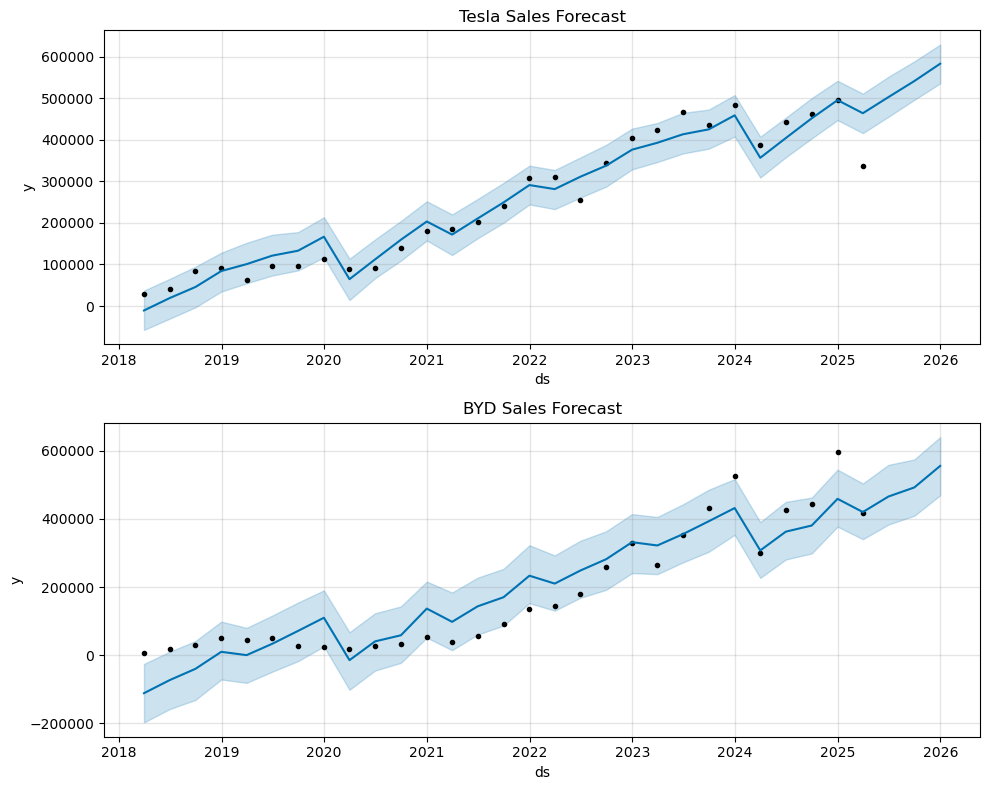

In [18]:
# Create subplots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8))

# Plot Tesla forecast
model_tesla.plot(forecast_tesla, ax=ax1)
ax1.set_title('Tesla Sales Forecast')

# Plot BYD forecast
model_byd.plot(forecast_byd, ax=ax2)
ax2.set_title('BYD Sales Forecast')

# Improve layout and plot
plt.tight_layout()
plt.show()


From comparing the two plots, it is evident that the model fits Tesla's sales data more accurately than BYD's. For Tesla, the forecast line closely follows the actual data points, suggesting a better model fit. In contrast, the forecast for BYD shows less accuracy — for example, it predicts sales below zero throughout 2018 (which is unrealistic), and overestimates sales during much of 2021 and 2022. Additionally, the uncertainty interval for BYD is significantly wider than for Tesla, indicating greater variability and less stability in the underlying data.

As we can see, Prophet forecasts steady growth in sales for both brands in Q2, Q3, and Q4 of 2025. The predicted volumes are printed below.

In [20]:
# Extract only the predicted future values
tesla_future_predictions = forecast_tesla[forecast_tesla['ds'] > df_tesla['ds'].max()][['ds', 'yhat']]
tesla_future_predictions['yhat'] = tesla_future_predictions['yhat'].round().astype(int)

byd_future_predictions = forecast_byd[forecast_byd['ds'] > df_byd['ds'].max()][['ds', 'yhat']]
byd_future_predictions['yhat'] = byd_future_predictions['yhat'].round().astype(int)

# Display the predictions
pred_byd_tesla = pd.merge(tesla_future_predictions, byd_future_predictions, on = 'ds', how = 'outer').rename(columns={'yhat_x': 'Tesla_sales_pred', 'yhat_y': 'BYD_sales_pred'})
pred_byd_tesla

,ds,Tesla_sales_pred,BYD_sales_pred
0,2025-06-30,503056,465887
1,2025-09-30,541661,492582
2,2025-12-31,583470,555814


The exact predicted numbers are shown above. To provide a clearer visual comparison, I will replot the Prophet results showing actual and predicted sales for Tesla and BYD.

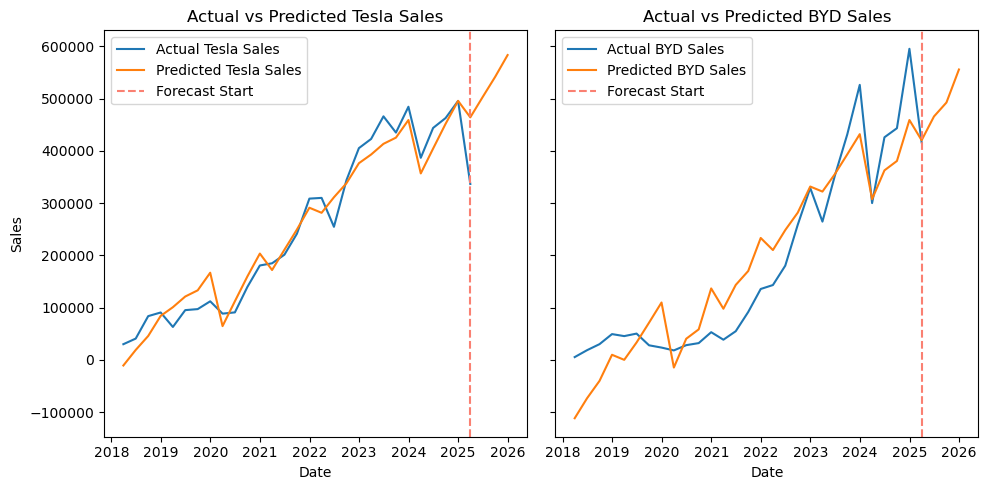

In [22]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5), sharey=True)

# Tesla plot
axes[0].plot(df_tesla['ds'], df_tesla['y'], label='Actual Tesla Sales')
axes[0].plot(forecast_tesla['ds'], forecast_tesla['yhat'], label='Predicted Tesla Sales')
axes[0].axvline(x=df_tesla['ds'].max(), color='salmon', linestyle='--', label='Forecast Start')
axes[0].legend()
axes[0].set_title('Actual vs Predicted Tesla Sales')
axes[0].set_xlabel('Date')
axes[0].set_ylabel('Sales')

# BYD plot
axes[1].plot(df_byd['ds'], df_byd['y'], label='Actual BYD Sales')
axes[1].plot(forecast_byd['ds'], forecast_byd['yhat'], label='Predicted BYD Sales')
axes[1].axvline(x=df_byd['ds'].max(), color='salmon', linestyle='--', label='Forecast Start')
axes[1].legend()
axes[1].set_title('Actual vs Predicted BYD Sales')
axes[1].set_xlabel('Date')

plt.tight_layout()
plt.show()


This visualization confirms the earlier observation that the default Prophet model performs less accurately on BYD sales. To quantify the model’s performance, I will calculate standard metrics such as MAE, RMSE, MAPE, and R-squared.

In [24]:
# BYD evaluation
eval_byd_df = df_byd.merge(forecast_byd[['ds', 'yhat']], on='ds')

mae_byd = mean_absolute_error(eval_byd_df['y'], eval_byd_df['yhat'])
rmse_byd = np.sqrt(mean_squared_error(eval_byd_df['y'], eval_byd_df['yhat']))
mape_byd = np.mean(np.abs((eval_byd_df['y'] - eval_byd_df['yhat']) / eval_byd_df['y'])) * 100
r2_byd = r2_score(eval_byd_df['y'], eval_byd_df['yhat'])

# Tesla evaluation
eval_tesla_df = df_tesla.merge(forecast_tesla[['ds', 'yhat']], on='ds')

mae_tesla = mean_absolute_error(eval_tesla_df['y'], eval_tesla_df['yhat'])
rmse_tesla = np.sqrt(mean_squared_error(eval_tesla_df['y'], eval_tesla_df['yhat']))
mape_tesla = np.mean(np.abs((eval_tesla_df['y'] - eval_tesla_df['yhat']) / eval_tesla_df['y'])) * 100
r2_tesla = r2_score(eval_tesla_df['y'], eval_tesla_df['yhat'])

# Create summary DataFrame
metrics_df = pd.DataFrame({
    'Model': ['Tesla', 'BYD'],
    'MAE': [mae_tesla, mae_byd],
    'RMSE': [rmse_tesla, rmse_byd],
    'MAPE (%)': [mape_tesla, mape_byd],
    'R2': [r2_tesla, r2_byd]
})

metrics_df

,Model,MAE,RMSE,MAPE (%),R2
0,Tesla,29067.247190,37469.824369,21.934975,0.941570
1,BYD,55802.343277,65992.804269,165.707340,0.864671


Tesla’s model performs noticeably better, with lower MAE, RMSE, and MAPE, and a higher R² score. The BYD model’s larger errors and lower R² reflect the challenges in accurately forecasting its sales with this baseline approach.

In the next step, I will attempt to improve the model's performance by tuning the Prophet hyperparameters. This may help to better capture the trends and seasonality, especially in the BYD sales data.

#### 1.2. Hyperparameter Tuning for Prophet

To tune the hyperparameters of the Prophet model, I will focus on two of the most general ones: changepoint_prior_scale and seasonality_prior_scale. To evaluate which values improve performance, I will split the available data into training and validation sets. Then, I will loop through a grid of selected parameter combinations, train the model on the training set, and make predictions on the validation set. Finally, I will calculate the MAE for each combination to identify which one gives the best result and optimizes the model’s performance.

I will begin by tuning the model for Tesla.

In [26]:
# Sort values
df_tesla = df_tesla.sort_values('ds')

# Calculate split index
split_index = int(len(df_tesla) * 0.8)

# Split into train and validation dataframes
train_df_tesla = df_tesla.iloc[:split_index]
val_df_tesla = df_tesla.iloc[split_index:]

In [28]:
# Define parameter grid
changepoint_prior_scale_values = [0.01, 0.1, 0.5]
seasonality_prior_scale_values = [0.01, 0.1, 1.0]

best_mae = float('inf')
best_params = {}
best_model = None

# Loop through the grid and evaluate the combination
for cps in changepoint_prior_scale_values:
    for sps in seasonality_prior_scale_values:
        # Set, fit, and forecast
        model = Prophet(
            changepoint_prior_scale=cps,
            seasonality_prior_scale=sps,
            yearly_seasonality=True,
            daily_seasonality=False,
            weekly_seasonality=True
        )
        model.fit(train_df_tesla)
        
        forecast = model.predict(val_df_tesla)
        mae = mean_absolute_error(val_df_tesla['y'], forecast['yhat'])

        # Print out the results
        print(f"cps={cps}, sps={sps}, MAE={mae:.2f}")
        
        if mae < best_mae:
            best_mae = mae
            best_params = {'changepoint_prior_scale': cps, 'seasonality_prior_scale': sps}
            best_model = model

print(f"\nBest parameters: {best_params}, Best MAE: {best_mae:.2f}")

cps=0.01, sps=0.01, MAE=64978.57
cps=0.01, sps=0.1, MAE=66518.41
cps=0.01, sps=1.0, MAE=62907.68
cps=0.1, sps=0.01, MAE=112988.29
cps=0.1, sps=0.1, MAE=66571.77
cps=0.1, sps=1.0, MAE=63303.02
cps=0.5, sps=0.01, MAE=145582.07
cps=0.5, sps=0.1, MAE=153867.35
cps=0.5, sps=1.0, MAE=175984.26

Best parameters: {'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 1.0}, Best MAE: 62907.68


Next, I’ll apply the same tuning process to the model for BYD.

In [30]:
# Sort values
df_byd = df_byd.sort_values('ds')

# Calculate split index
split_index = int(len(df_byd) * 0.8)

# Split into train and validation dataframes
train_df_byd = df_byd.iloc[:split_index]
val_df_byd = df_byd.iloc[split_index:]

In [32]:
# Define parameter grid
changepoint_prior_scale_values = [0.01, 0.1, 0.5]
seasonality_prior_scale_values = [0.01, 0.1, 1.0]

best_mae = float('inf')
best_params = {}
best_model = None

# Loop through the grid and evaluate the combination
for cps in changepoint_prior_scale_values:
    for sps in seasonality_prior_scale_values:
        # Set, fit, and forecast
        model = Prophet(
            changepoint_prior_scale=cps,
            seasonality_prior_scale=sps,
            yearly_seasonality=True,
            daily_seasonality=False,
            weekly_seasonality=True
        )
        model.fit(train_df_byd)
        
        forecast = model.predict(val_df_byd)
        mae = mean_absolute_error(val_df_byd['y'], forecast['yhat'])

        # Print out the results
        print(f"cps={cps}, sps={sps}, MAE={mae:.2f}")
        
        if mae < best_mae:
            best_mae = mae
            best_params = {'changepoint_prior_scale': cps, 'seasonality_prior_scale': sps}
            best_model = model

print(f"\nBest params: {best_params}, Best MAE: {best_mae:.2f}")

cps=0.01, sps=0.01, MAE=112718.23
cps=0.01, sps=0.1, MAE=87674.78
cps=0.01, sps=1.0, MAE=89606.65
cps=0.1, sps=0.01, MAE=112545.98
cps=0.1, sps=0.1, MAE=110305.28
cps=0.1, sps=1.0, MAE=127268.44
cps=0.5, sps=0.01, MAE=110619.64
cps=0.5, sps=0.1, MAE=102614.78
cps=0.5, sps=1.0, MAE=129160.46

Best params: {'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 0.1}, Best MAE: 87674.78


To evaluate the Prophet model’s performance for Tesla and BYD with tuned hyperparameters, I compared the MAE from the default model to the best MAE found during tuning. In both cases, the MAE increased compared to the default model: from __29,067.25__ to __62,907.68__ for __Tesla__, and from __55,802.34__ to __87,674.78__ for __BYD__.

The tuning was performed over a grid of two general parameters with 3 values each (9 combinations), using only 80% of the data for training. This training set covers the earlier historical period, while the remaining 20% serves as a validation set with more recent data. This split and the higher MAE reflect differences in sales trends over time, as confirmed by the EDA.

Although retraining the tuned model on the full dataset might improve the MAE compared to the 80% subset, it is unlikely to outperform the default model’s results. Therefore, the default model can be considered the most accurate for forecasting sales with this data.

## 2. Training and Forecasting with Added Stock Market Data

Parameter tuning did not yield improvements over the baseline model. Therefore, in this section, I will enhance the dataset by integrating available stock market data identified during the exploratory data analysis. While the correlation between stock market behavior and sales may not be strong, given that many factors influence stock prices, a key metric to anticipate investor sentiment is the lagged stock return, which in this context represents the return from the previous quarter.

The first step is to read the stock market data into a DataFrame.

In [34]:
stm_q = pd.read_csv('/Users/alex/Documents/Work/Projects for portfolio/EV Stocks and Sales/Stock_Market_Quarterly.csv')

To incorporate additional features (regressors), Prophet requires that these regressors have values for every forecasted period. In this case, to forecast sales for Q2, Q3, and Q4 of 2025, the dataset must include the lagged quarterly stock returns (LSR) corresponding to these future quarters.

I will begin by extending the dataset with the LSR value for Q2 2025, using the previous quarter’s stock return.

In [36]:
# Get last known QR values for lag
last_tesla_qr = stm_q.loc[stm_q.index[-1], 'Tesla_QR']
last_byd_qr = stm_q.loc[stm_q.index[-1], 'BYD_QR']

# Create the next quarter date
next_q_date = pd.date_range(start=stm_q['Date'].iloc[-1], periods=2, freq='QE')[1]

# Create the new row
new_row = pd.DataFrame({
    'Date': [next_q_date],
    'Tesla_Close': [np.nan],
    'BYD_Close': [np.nan],
    'Tesla_QR': [np.nan],
    'BYD_QR': [np.nan],
    'Tesla_QR_lag1': last_tesla_qr,
    'BYD_QR_lag1': last_byd_qr
})

# Append
stm_q_extended = pd.concat([stm_q, new_row], ignore_index=True)

stm_q_extended.tail(3)

,Date,Tesla_Close,BYD_Close,Tesla_QR,BYD_QR,Tesla_Volat,BYD_Volat,Tesla_QR_lag1,BYD_QR_lag1
27,2024-12-31 00:00:00-05:00,321.742657,71.145937,0.410851,0.187315,0.045218,0.028390,0.304855,0.086942
28,2025-03-31 00:00:00-04:00,334.519321,85.281187,0.039711,0.198680,0.041800,0.030583,0.410851,0.187315
29,2025-06-30 00:00:00-04:00,NaN,NaN,NaN,NaN,NaN,NaN,0.039711,0.198680


The dataframe is reduced to the necessary features.

In [38]:
stm_q = stm_q_extended[['Date', 'Tesla_QR_lag1', 'BYD_QR_lag1']]

The data for Q3 and Q4 of 2025 does not exist yet. To address this, I will estimate these missing values using linear regression. While this approach is not perfect and may introduce some uncertainty, it provides a reasonable approximation to allow the model to incorporate lagged stock returns for forecasting these future quarters.

In [40]:
# Create a temporary copy and drop missing lag values
df = stm_q.copy()
df_model = df.dropna(subset=['Tesla_QR_lag1', 'BYD_QR_lag1'])

# Train Tesla model
X_tesla = df_model[['Tesla_QR_lag1']].iloc[:-1]
y_tesla = df_model['Tesla_QR_lag1'].shift(-1).dropna()
model_tesla = LinearRegression().fit(X_tesla, y_tesla)

# Train BYD model
X_byd = df_model[['BYD_QR_lag1']].iloc[:-1]
y_byd = df_model['BYD_QR_lag1'].shift(-1).dropna()
model_byd = LinearRegression().fit(X_byd, y_byd)

# Define last known lagged QR values
tesla_qr_lag1_q3 = df_model['Tesla_QR_lag1'].iloc[-1]
byd_qr_lag1_q3 = df_model['BYD_QR_lag1'].iloc[-1]

# Predict Q3 2025
tesla_pred_q3 = model_tesla.predict(pd.DataFrame({'Tesla_QR_lag1': [tesla_qr_lag1_q3]}))[0]
byd_pred_q3 = model_byd.predict(pd.DataFrame({'BYD_QR_lag1': [byd_qr_lag1_q3]}))[0]

# Predict Q4 2025 using Q3 prediction as new lag
tesla_pred_q4 = model_tesla.predict(pd.DataFrame({'Tesla_QR_lag1': [tesla_pred_q3]}))[0]
byd_pred_q4 = model_byd.predict(pd.DataFrame({'BYD_QR_lag1': [byd_pred_q3]}))[0]

# Create new prediction rows
new_dates = pd.to_datetime(['2025-09-30', '2025-12-31'])
future_df = pd.DataFrame({
    'Date': new_dates,
    'Tesla_QR_lag1': [tesla_pred_q3, tesla_pred_q4],
    'BYD_QR_lag1': [byd_pred_q3, byd_pred_q4],
})

# Concatenate with original data
stm_q = pd.concat([df, future_df], ignore_index=True)

# Display the result
stm_q.tail()

,Date,Tesla_QR_lag1,BYD_QR_lag1
27,2024-12-31 00:00:00-05:00,0.304855,0.086942
28,2025-03-31 00:00:00-04:00,0.410851,0.187315
29,2025-06-30 00:00:00-04:00,0.039711,0.198680
30,2025-09-30 00:00:00,0.109030,0.147078
31,2025-12-31 00:00:00,0.136584,0.125742


In the next step, I will create brand-specific dataframes by merging the sales data with the corresponding stock market data. This will allow the model to use both sales and lagged stock return features for each brand in the forecasting process.

In [42]:
# Convert stock market dates to datetime with UTC
stm_q['Date'] = pd.to_datetime(stm_q['Date'], utc=True)

# Remove timezone and time by normalizing to midnight date
stm_q['Date'] = stm_q['Date'].dt.tz_convert(None).dt.normalize()

# Create brand-specific dataframes
tesla_stm_q = stm_q[['Date', 'Tesla_QR_lag1']].rename(columns={'Date':'ds','Tesla_QR_lag1':'x1'})
byd_stm_q = stm_q[['Date', 'BYD_QR_lag1']].rename(columns={'Date':'ds','BYD_QR_lag1':'x1'})

# Merge stock market and sales data
df_tesla_stm_q = pd.merge(df_tesla, tesla_stm_q, on='ds', how='outer')
df_byd_stm_q = pd.merge(df_byd, byd_stm_q, on='ds', how='outer')

# Drop NaN rows
df_tesla_stm_q = df_tesla_stm_q.dropna(subset=['x1']).reset_index(drop=True)
df_byd_stm_q = df_byd_stm_q.dropna(subset=['x1']).reset_index(drop=True)

Finally, I will fit separate Prophet models for each brand using the combined sales data and lagged stock returns, then generate forecasts for the next three quarters.

In [44]:
# Set and fit the model
model_tesla_stm_q = Prophet()
model_tesla_stm_q.add_regressor('x1')
model_tesla_stm_q.fit(df_tesla_stm_q)
# Forecast next 3 quarters
future_tesla_stm_q = df_tesla_stm_q[['ds', 'x1']].copy()
forecast_tesla_stm_q = model_tesla_stm_q.predict(future_tesla_stm_q)
#forecast_tesla_stm_q['yhat'] = forecast_tesla_stm_q['yhat'].clip(lower=0)

In [46]:
# Set and fit the model
model_byd_stm_q = Prophet()
model_byd_stm_q.add_regressor('x1')
model_byd_stm_q.fit(df_byd_stm_q)
# Forecast next 3 quarters
future_byd_stm_q = df_byd_stm_q[['ds', 'x1']].copy()
forecast_byd_stm_q = model_byd_stm_q.predict(future_byd_stm_q)
#forecast_byd_stm_q['yhat'] = forecast_byd_stm_q['yhat'].clip(lower=0)

The same as before, I will visualize the Prophet model forecasts to compare actual and predicted sales.

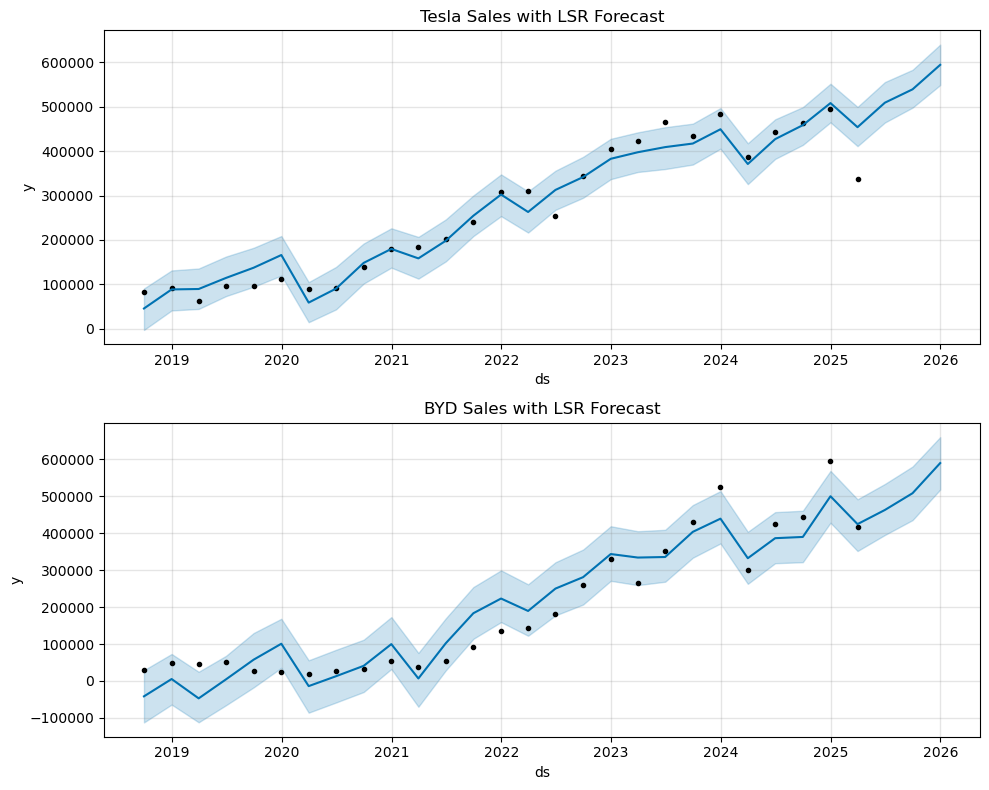

In [48]:
# Create subplots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8))

# Plot Tesla forecast
model_tesla_stm_q.plot(forecast_tesla_stm_q, ax=ax1)
ax1.set_title('Tesla Sales with LSR Forecast')

# Plot BYD forecast
model_byd_stm_q.plot(forecast_byd_stm_q, ax=ax2)
ax2.set_title('BYD Sales with LSR Forecast')

# Improve layout and plot
plt.tight_layout()
plt.show()

Below, we compare the predicted sales from the baseline Prophet model and the model trained with lagged quarterly stock returns as an additional regressor.

In [50]:
# Extract only the predicted future values
tesla_stm_q_future_predictions = forecast_tesla_stm_q[forecast_tesla_stm_q['ds'] > df_tesla['ds'].max()][['ds', 'yhat']]
tesla_stm_q_future_predictions['yhat'] = tesla_stm_q_future_predictions['yhat'].round().astype(int)

byd_stm_q_future_predictions = forecast_byd_stm_q[forecast_byd_stm_q['ds'] > df_byd['ds'].max()][['ds', 'yhat']]
byd_stm_q_future_predictions['yhat'] = byd_stm_q_future_predictions['yhat'].round().astype(int)

# Display the predictions
pred_byd_tesla_stm_q = pd.merge(tesla_stm_q_future_predictions, byd_stm_q_future_predictions, on = 'ds', how = 'outer').rename(columns={'yhat_x': 'Tesla_sales_LSR_pred', 'yhat_y': 'BYD_sales_LSR_pred'})
pred_byd_tesla_stm_q_comb = pd.merge(pred_byd_tesla, pred_byd_tesla_stm_q, on = 'ds', how = 'outer')
pred_byd_tesla_stm_q_comb.to_csv('/Users/alex/Documents/Work/Projects for portfolio/EV Stocks and Sales/EV_For Tableau/ML_Prophet_pred_quart.csv')
pred_byd_tesla_stm_q_comb

,ds,Tesla_sales_pred,BYD_sales_pred,Tesla_sales_LSR_pred,BYD_sales_LSR_pred
0,2025-06-30,503056,465887,509238,463010
1,2025-09-30,541661,492582,539307,508363
2,2025-12-31,583470,555814,594483,589994


We observe that while both models indicate quarterly growth, the model incorporating stock market data predicts sales with differences measured in thousands, reflecting more nuanced adjustments compared to the baseline.

The following line plots display the actual sales alongside predictions from both the baseline and the lagged stock return models for comparison.

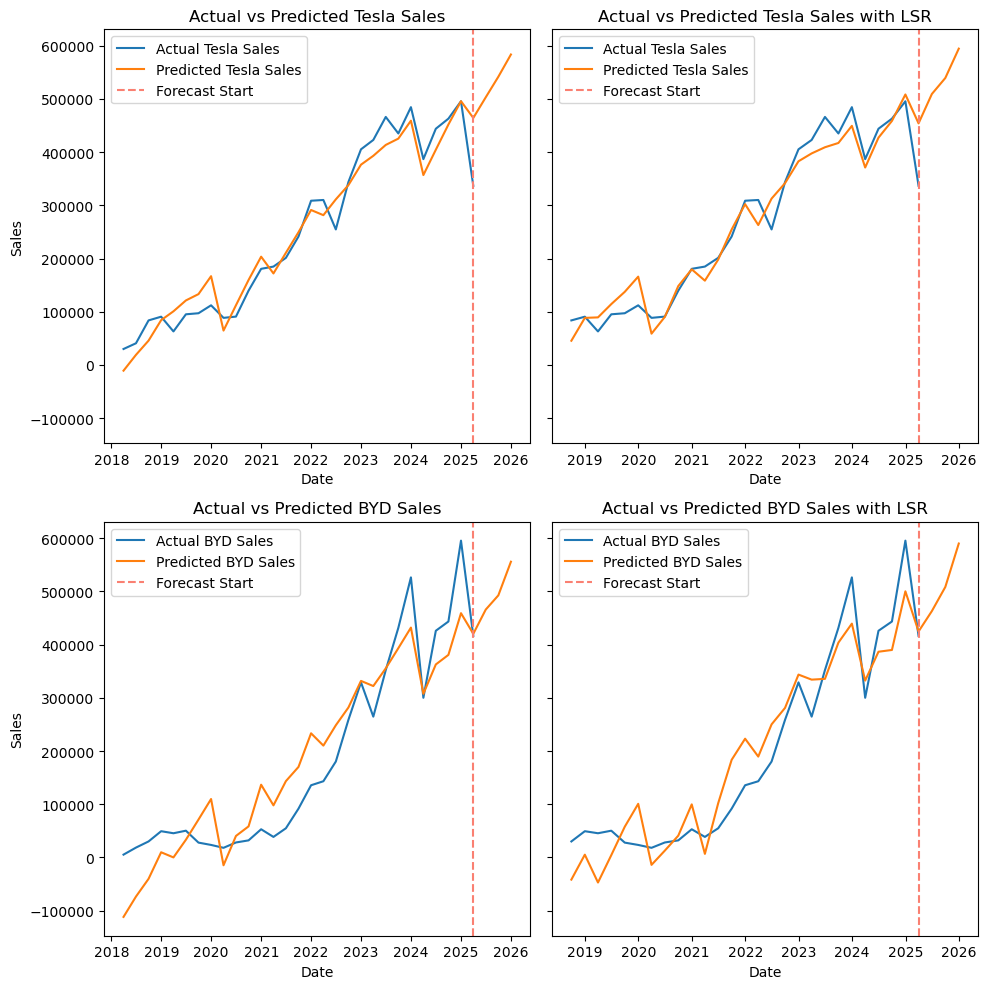

In [52]:
fig, axes = plt.subplots(2, 2, figsize=(10, 10), sharey=True)

# Tesla plot
axes[0, 0].plot(df_tesla['ds'], df_tesla['y'], label='Actual Tesla Sales')
axes[0, 0].plot(forecast_tesla['ds'], forecast_tesla['yhat'], label='Predicted Tesla Sales')
axes[0, 0].axvline(x=df_tesla['ds'].max(), color='salmon', linestyle='--', label='Forecast Start')
axes[0, 0].legend()
axes[0, 0].set_title('Actual vs Predicted Tesla Sales')
axes[0, 0].set_xlabel('Date')
axes[0, 0].set_ylabel('Sales')

# BYD plot# Tesla plot with stock market data
axes[0, 1].plot(df_tesla_stm_q['ds'], df_tesla_stm_q['y'], label='Actual Tesla Sales')
axes[0, 1].plot(forecast_tesla_stm_q['ds'], forecast_tesla_stm_q['yhat'], label='Predicted Tesla Sales')
axes[0, 1].axvline(x=df_tesla_stm_q['ds'].iloc[-4], color='salmon', linestyle='--', label='Forecast Start')
axes[0, 1].legend()
axes[0, 1].set_title('Actual vs Predicted Tesla Sales with LSR')
axes[0, 1].set_xlabel('Date')

# BYD plot
axes[1, 0].plot(df_byd['ds'], df_byd['y'], label='Actual BYD Sales')
axes[1, 0].plot(forecast_byd['ds'], forecast_byd['yhat'], label='Predicted BYD Sales')
axes[1, 0].axvline(x=df_byd['ds'].max(), color='salmon', linestyle='--', label='Forecast Start')
axes[1, 0].legend()
axes[1, 0].set_title('Actual vs Predicted BYD Sales')
axes[1, 0].set_xlabel('Date')
axes[1, 0].set_ylabel('Sales')

# BYD plot with stock market data
axes[1, 1].plot(df_byd_stm_q['ds'], df_byd_stm_q['y'], label='Actual BYD Sales')
axes[1, 1].plot(forecast_byd_stm_q['ds'], forecast_byd_stm_q['yhat'], label='Predicted BYD Sales')
axes[1, 1].axvline(x=df_byd_stm_q['ds'].iloc[-4], color='salmon', linestyle='--', label='Forecast Start')
axes[1, 1].legend()
axes[1, 1].set_title('Actual vs Predicted BYD Sales with LSR')
axes[1, 1].set_xlabel('Date')

plt.tight_layout()
plt.show()

Both pairs of plots indicate adjustments in the predictions. For BYD, these changes are more pronounced than for Tesla. Additionally, we observe differences in the forecast trends.

The evaluation metrics for both models are presented in the table below.

In [54]:
# BYD with LSR evaluation
eval_byd_stm_q_df = df_byd_stm_q.merge(forecast_byd_stm_q[['ds', 'yhat']], on='ds')
eval_byd_stm_q_df = eval_byd_stm_q_df[eval_byd_stm_q_df['y'].notna()]

mae_byd_stm_q = mean_absolute_error(eval_byd_stm_q_df['y'], eval_byd_stm_q_df['yhat'])
rmse_byd_stm_q = np.sqrt(mean_squared_error(eval_byd_stm_q_df['y'], eval_byd_stm_q_df['yhat']))
mape_byd_stm_q = np.mean(np.abs((eval_byd_stm_q_df['y'] - eval_byd_stm_q_df['yhat']) / eval_byd_stm_q_df['y'])) * 100
r2_byd_stm_q = r2_score(eval_byd_stm_q_df['y'], eval_byd_stm_q_df['yhat'])

# Tesla with LSR evaluation
eval_tesla_stm_q_df = df_tesla_stm_q.merge(forecast_tesla_stm_q[['ds', 'yhat']], on='ds')
eval_tesla_stm_q_df = eval_tesla_stm_q_df[eval_tesla_stm_q_df['y'].notna()]

mae_tesla_stm_q = mean_absolute_error(eval_tesla_stm_q_df['y'], eval_tesla_stm_q_df['yhat'])
rmse_tesla_stm_q = np.sqrt(mean_squared_error(eval_tesla_stm_q_df['y'], eval_tesla_stm_q_df['yhat']))
mape_tesla_stm_q = np.mean(np.abs((eval_tesla_stm_q_df['y'] - eval_tesla_stm_q_df['yhat']) / eval_tesla_stm_q_df['y'])) * 100
r2_tesla_stm_q = r2_score(eval_tesla_stm_q_df['y'], eval_tesla_stm_q_df['yhat'])

# Create updated summary DataFrame
metrics_df_stm_q = pd.DataFrame({
    'Model': ['Tesla', 'Tesla with LSR', 'BYD', 'BYD with LSR'],
    'MAE': [mae_tesla, mae_tesla_stm_q, mae_byd, mae_byd_stm_q],
    'RMSE': [rmse_tesla, rmse_tesla_stm_q, rmse_byd, rmse_byd_stm_q],
    'MAPE (%)': [mape_tesla, mape_tesla_stm_q, mape_byd, mape_byd_stm_q],
    'R2': [r2_tesla, r2_tesla_stm_q, r2_byd, r2_byd_stm_q]
})

metrics_df_stm_q.to_csv('/Users/alex/Documents/Work/Projects for portfolio/EV Stocks and Sales/EV_For Tableau/ML_Prophet_metrics.csv')
metrics_df_stm_q

,Model,MAE,RMSE,MAPE (%),R2
0,Tesla,29067.247190,37469.824369,21.934975,0.941570
1,Tesla with LSR,25974.753395,35981.182963,14.221341,0.941381
2,BYD,55802.343277,65992.804269,165.707340,0.864671
3,BYD with LSR,48356.098808,55532.476068,71.357025,0.904149


The table above summarizes the evaluation metrics for both baseline and LSR-enhanced models. Incorporating lagged stock returns noticeably improved the performance for both brands, particularly for BYD.

For __Tesla__, the Mean Absolute Error (__MAE__) decreased from approximately __29,067__ to __25,975__, and the Root Mean Squared Error (__RMSE__) improved from about __37,470__ to __35,981__. The Mean Absolute Percentage Error (__MAPE__) dropped significantly from __21.93%__ to __14.22%__, indicating much better relative accuracy. The __R²__ score remained steady around __0.94__, showing that the model's explanatory power is consistent.

BYD’s improvement is even more substantial. The __MAE__ decreased from roughly __55,802__ to __48,356__, and the __RMSE__ dropped from about __65,993__ to __55,532__. The __MAPE__ saw a dramatic reduction from __165.7%__ to __71.36%__, which reflects much better handling of BYD’s volatile sales. The __R²__ increased from __0.86__ to __0.90__, indicating a notably better fit.

## 3. Conclusion

Predictive modeling with Prophet was conducted in three stages: initial training on quarterly sales data for both BYD and Tesla, model tuning with parameter adjustments, and finally, training with an additional external regressor — lagged quarterly stock returns. Evaluation results suggest that including lagged stock returns improved predictive performance, particularly for the more volatile BYD sales data.

While sales volumes over the period exhibited strong seasonality and notable yearly spikes, the model still produced meaningful forecasts, especially for Tesla, whose sales were more stable. To further enhance the model’s accuracy and robustness, additional data would be beneficial.

Future improvements could include incorporating other external variables, such as macroeconomic indicators or policy changes, or testing alternative forecasting methods for comparison.

#### Exporting Sales Data for Tableau Presentation

In [56]:
# Extract and merge Tesla and BYD actual sales
df_tesla_exp = df_tesla_stm_q[['ds', 'y']]
df_tesla_exp = df_tesla_exp.rename(columns={'y': 'Tesla_Sales'})
df_byd_exp = df_byd_stm_q[['ds', 'y']]
df_byd_exp = df_byd_exp.rename(columns={'y': 'BYD_Sales'})
df_tesla_byd_exp = pd.merge(df_tesla_exp, df_byd_exp, on='ds', how='left')

# Extract and merge Tesla and BYD predicted sales
forecast_tesla_exp = forecast_tesla_stm_q[['ds', 'yhat']]
forecast_tesla_exp = forecast_tesla_exp.rename(columns={'yhat':'Tesla_Pred_Sales'})
forecast_byd_exp = forecast_byd_stm_q[['ds', 'yhat']]
forecast_byd_exp = forecast_byd_exp.rename(columns={'yhat':'BYD_Pred_Sales'})
forecast_tesla_byd_exp = pd.merge(forecast_tesla_exp, forecast_byd_exp, on='ds', how='left')

# Merge into one dataframe
forecast_exp = pd.merge(df_tesla_byd_exp, forecast_tesla_byd_exp, on='ds', how='left')

# Export as csv
forecast_exp.to_csv('/Users/alex/Documents/Work/Projects for portfolio/EV Stocks and Sales/EV_For Tableau/Prophet_Forecast.csv')